## ECE 579M ST: Machine Learning in Cybersecurity
### Project Two: Adversarial Image Crafting
#### Blended Uniform Noise Attack

---
## Step 0: Import required packages

In [1]:
## LIST OF ALL IMPORTS
import sys
import os
import csv
import math
import random
import time
import os.path as path
import cv2
import glob
import numpy as np
from numpy.random import randint, RandomState

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import keras
import tensorflow as tf
from keras import backend as K
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input,decode_predictions

from foolbox.models import KerasModel
from foolbox.attacks import BlendedUniformNoiseAttack, FGSM
from foolbox.criteria import Misclassification, TopKMisclassification, OriginalClassProbability
from foolbox.criteria import TargetClass, TargetClassProbability

from utils import expand_dims, kpredictions, load_image, normalize01

# Visualizations will be shown in the notebook.
%matplotlib inline 

Using TensorFlow backend.


---
## Step 1: Load Pretrained Model

In [2]:
# ImageNet used to train ResNet-50

model=ResNet50(include_top=True,
               weights='imagenet',
               input_tensor=None,
               input_shape=None,
               pooling=None,
               classes=1000)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

Total params: 25,636,712
Trainable params: 25,583,592
Non-trainable params: 53,120
__________________________________________________________________________________________________


#### Visualizing predictions on the trained model

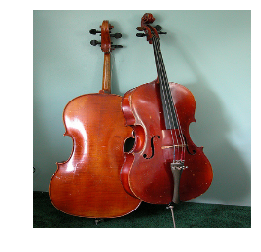

Image shape (224, 224, 3), max element val: 255, min element val: 0, mean element val: 114.6


In [3]:
image_path='sample_images/*.jpg'
glob_paths=glob.glob(image_path)
random_index=randint(0,len(glob_paths))

chosenimage_fname=glob_paths[random_index]
load=cv2.imread(chosenimage_fname) # BGR order
resized_image=cv2.resize(load,(224,224))

plt.imshow(resized_image[:,:,::-1]) # Back to RGB format
plt.axis('off')
plt.show()

print("Image shape {}, max element val: {}, min element val: {}, mean element val: {}"
      .format(resized_image.shape,np.max(resized_image),np.min(resized_image),round(np.mean(resized_image),1)))

model_input_image=np.expand_dims(resized_image,axis=0)

In [4]:
image_name=chosenimage_fname.replace('sample_images/','').replace('.jpg','')
predictions=model.predict(model_input_image)
label=int(np.argmax(model.predict(model_input_image),axis=-1))

top_k=decode_predictions(predictions,top=5)

print("Sample Testing image is {} with a label of {}.\n".format(image_name,label))


print('Top-K Predictions: ')
print([top_k[0][i][1:3] for i in range(5)])

Sample Testing image is cello with a label of 486.

Top-K Predictions: 
[('cello', 0.85294169), ('violin', 0.14697221), ('acoustic_guitar', 5.2528718e-05), ('banjo', 2.3409033e-05), ('electric_guitar', 5.2939517e-06)]


----

## Step 2: Crafting Adversarial Images

The goal is to build rogue/adversarial images that fool ML classifiers (ResNet50) with high confidence using Foolbox package.

1. foolbox.models: Wrap models with different frameworks (Tensorflow, Keras, Pytorch etc).
2. foolbox.criteria: Creates adversarial images targeted to:
                            1. Misclassification: Predicted class is not the original class.
                            2. Top-K Misclassification: Predicted k-classes doesn't contain the original class.
                            3. Original Class Probability: Probability of original class is below a threshold.
                            4. Target Class: Predicted class is the given target class.
                            5. Target Class Probability: Predicted class is the given target above a threshold. 
3. foolbox.distances: Distance metric between images (mean-squared error, or mean-absolute error).
4. foolbox.attacks: Types of adversarial attacks that can be run.
                            1. Gradient-based
                            2. Score-based 
                            3. Decision-based 

In [5]:
num_images=10 # Number of images for each attack type

---
### 2.1: Minimal Working Example

In [6]:
from foolbox.utils import imagenet_example
sample_image,sample_label=imagenet_example()
keras.backend.set_learning_phase(0)

In [7]:
preprocessing = (np.array([104, 116, 123]),1)

attack_model=KerasModel(model,bounds=(0,255),preprocessing=preprocessing)
fgsm_test_attack=FGSM(attack_model)
adversarial_image=fgsm_test_attack(image=sample_image[:,:,::-1],label=sample_label) # Expects BGR images

In [8]:
difference=sample_image-adversarial_image[:,:,::-1]
difference=difference/np.max(abs(difference))*0.2 +0.5

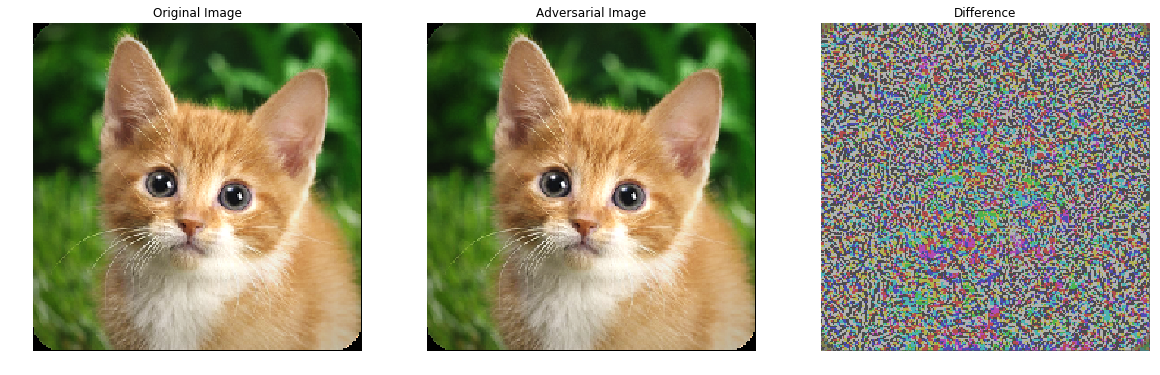

In [9]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,10))
ax1.set_title('Original Image')
ax1.imshow(sample_image/255.)
ax1.axis('off')

ax2.set_title('Adversarial Image')
ax2.imshow(adversarial_image[:,:,::-1]/255.)
ax2.axis('off')

ax3.set_title('Difference')

ax3.imshow((difference))
ax3.axis('off')

plt.show()

In [10]:
kpredictions(sample_image[:,:,::-1],model,5)

[('lynx', 0.2934216),
 ('tiger_cat', 0.24608396),
 ('tabby', 0.16798218),
 ('Egyptian_cat', 0.10649589),
 ('Siamese_cat', 0.040988304)]

In [11]:
kpredictions(adversarial_image[:,:,::-1],model,5)

[('lynx', 0.2839345),
 ('Siamese_cat', 0.065981783),
 ('Persian_cat', 0.056728143),
 ('Egyptian_cat', 0.055930976),
 ('grey_fox', 0.052765496)]

---
### 2.2: Blended Uniform Noise Attack

TopKMisclassification for Blended Uniform Noise Attack outputs uniform noise for adversarial image

Attacking swissmountain_dog image:


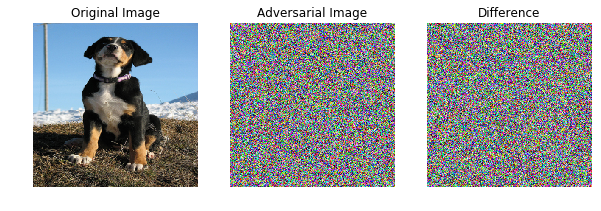

Time taken 64.01 s
Top Three original image predictions:
[('EntleBucher', 0.50947666), ('Greater_Swiss_Mountain_dog', 0.38868508), ('Appenzeller', 0.035090648)]
Top Three adversarial image predictions:
[('fire_screen', 0.19215852), ('pole', 0.1637717), ('window_screen', 0.079887457)]


Attacking monkey_dog image:


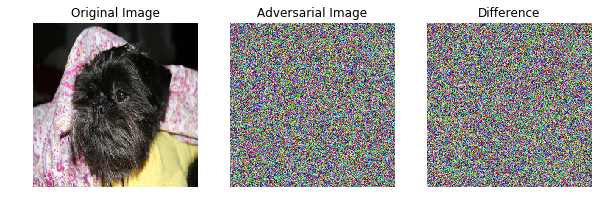

Time taken 149.5 s
Top Three original image predictions:
[('affenpinscher', 0.95030755), ('Brabancon_griffon', 0.037189797), ('miniature_schnauzer', 0.0037101922)]
Top Three adversarial image predictions:
[('fire_screen', 0.24356309), ('pole', 0.17173466), ('window_screen', 0.077253781)]


Attacking polar_bear image:


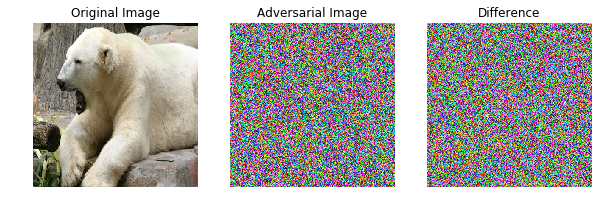

Time taken 303.4 s
Top Three original image predictions:
[('ice_bear', 0.99766207), ('brown_bear', 0.0011053918), ('gorilla', 0.00015318922)]
Top Three adversarial image predictions:
[('pole', 0.17904425), ('fire_screen', 0.10660762), ('window_screen', 0.068752393)]


Attacking fire_engine image:


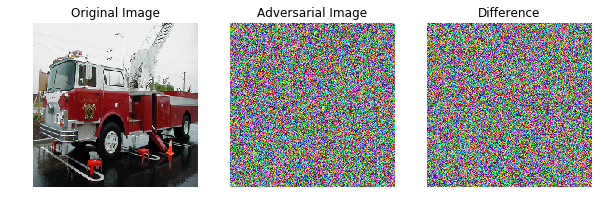

Time taken 276.72 s
Top Three original image predictions:
[('fire_engine', 0.99913043), ('tow_truck', 0.00037051775), ('trailer_truck', 0.00035099123)]
Top Three adversarial image predictions:
[('fire_screen', 0.21440464), ('pole', 0.11087206), ('window_screen', 0.061448727)]


Attacking mushroom image:


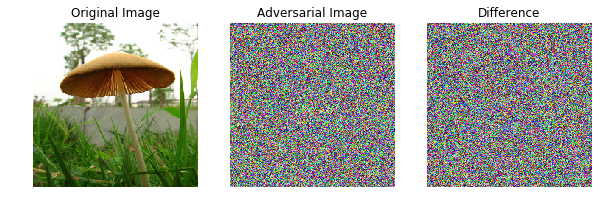

Time taken 325.62 s
Top Three original image predictions:
[('mushroom', 0.98872489), ('carousel', 0.0045765438), ('agaric', 0.0039199684)]
Top Three adversarial image predictions:
[('fire_screen', 0.18466274), ('pole', 0.1343632), ('window_screen', 0.075894795)]


Attacking blimp image:


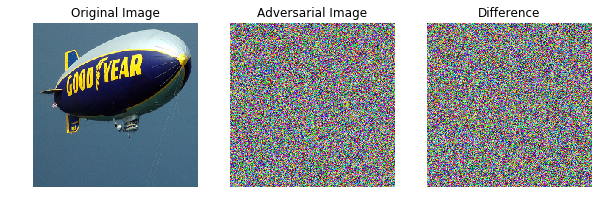

Time taken 349.32 s
Top Three original image predictions:
[('airship', 0.99999487), ('airliner', 3.7123814e-06), ('rugby_ball', 4.7209878e-07)]
Top Three adversarial image predictions:
[('fire_screen', 0.41769955), ('pole', 0.13518663), ('window_screen', 0.054255579)]


Attacking cello image:


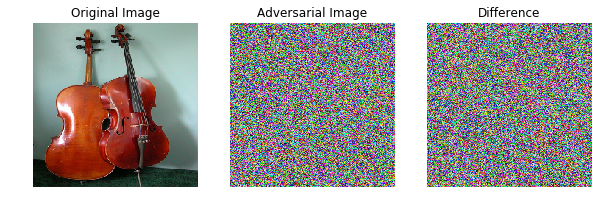

Time taken 296.13 s
Top Three original image predictions:
[('cello', 0.85294169), ('violin', 0.14697221), ('acoustic_guitar', 5.2528718e-05)]
Top Three adversarial image predictions:
[('pole', 0.15328641), ('fire_screen', 0.11050898), ('window_screen', 0.08654841)]


Attacking pineapple image:


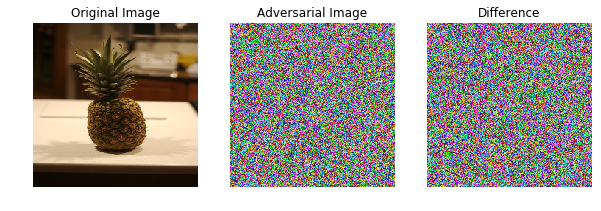

Time taken 158.53 s
Top Three original image predictions:
[('pineapple', 0.9999789), ('acorn', 7.0041001e-06), ('sea_urchin', 5.8159744e-06)]
Top Three adversarial image predictions:
[('fire_screen', 0.35226586), ('pole', 0.16868198), ('window_screen', 0.058879498)]


Attacking orange image:


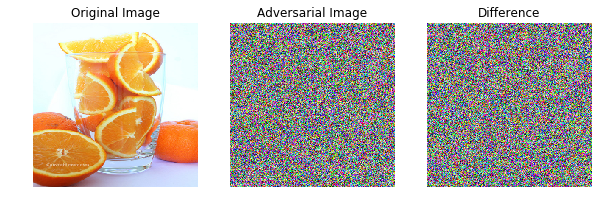

Time taken 69.36 s
Top Three original image predictions:
[('orange', 0.59438312), ('lemon', 0.37366846), ('candle', 0.026762435)]
Top Three adversarial image predictions:
[('fire_screen', 0.25695875), ('pole', 0.11202227), ('window_screen', 0.066637471)]


Attacking sweet_potato image:


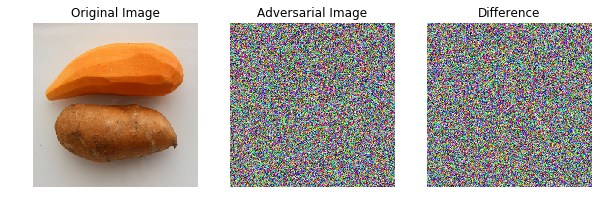

Time taken 46.27 s
Top Three original image predictions:
[('butternut_squash', 0.53446132), ('French_loaf', 0.16046521), ('bolete', 0.063428879)]
Top Three adversarial image predictions:
[('fire_screen', 0.34504658), ('pole', 0.19937587), ('window_screen', 0.09052299)]


Finished in 2056.25 s


In [12]:
init_time=time.time()
random_index=np.random.choice(len(glob_paths),10,replace=False)
chosenimage_fname=[str(glob_paths[ind]) for ind in random_index]

for ind in range(len(chosenimage_fname)):
    start_time=time.time()
    model_image,label=load_image(chosenimage_fname[ind],model)

    criterion=OriginalClassProbability(0.3)
    attack_model=KerasModel(model,bounds=(0,255))
    bun_attack=BlendedUniformNoiseAttack(attack_model,criterion=criterion)
    adversarial_image=bun_attack(image=model_image,label=label)
    
    difference=normalize01(model_image-adversarial_image)
    
    stop_time=time.time()
    image_name=chosenimage_fname[ind].replace('sample_images/','').replace('.jpg','')
    print("Attacking {} image:".format(image_name))
    fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,10))
    ax1.set_title('Original Image')
    ax1.imshow(model_image[:,:,::-1])
    ax1.axis('off')

    ax2.set_title('Adversarial Image')
    ax2.imshow(adversarial_image[:,:,::-1]/255)
    ax2.axis('off')

    ax3.set_title('Difference')

    ax3.imshow((normalize01(difference)))
    ax3.axis('off')

    plt.show()
    print("Time taken {} s".format(round(stop_time-start_time,2)))
    print("Top Three original image predictions:")
    print(kpredictions(model_image,model,3))
    print("Top Three adversarial image predictions:")
    print(kpredictions(adversarial_image,model,3))
    print("\n")
end_time=time.time()
print("Finished in {} s".format(round(end_time-init_time,2)))